In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('data/cleaned_dataset.csv')

initial_columns_count = data.shape[1]

data = data.loc[:, ~data.columns.duplicated()]

final_columns_count = data.shape[1]

duplicates_removed = initial_columns_count - final_columns_count

print(f"Number of duplicate columns removed: {duplicates_removed}")


Number of duplicate columns removed: 0


In [ ]:
texts = data['Attractions'].tolist()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()  # Set the model to evaluation mode


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
def get_embedding(text):
    with torch.no_grad():
        inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        outputs = bert_model(**inputs)
        embeddings = outputs.last_hidden_state  # Token embeddings
        embeddings = embeddings.mean(dim=1)     # Mean pooling
    return embeddings.squeeze().cpu().numpy()

In [ ]:
from tqdm import tqdm
embeddings = []
for text in tqdm(texts, desc="Generating embeddings"):
    emb = get_embedding(text)
    embeddings.append(emb)

embeddings = np.array(embeddings)

Generating embeddings: 100%|██████████| 1516/1516 [00:40<00:00, 37.29it/s]


In [ ]:
def add_noise(data, noise_factor=0.1):
    noisy_data = data + noise_factor * np.random.randn(*data.shape)
    return noisy_data


In [ ]:
noisy_embeddings = add_noise(embeddings)

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class EmbeddingDataset(Dataset):
    def __init__(self, noisy_data, clean_data):
        self.noisy_data = torch.tensor(noisy_data, dtype=torch.float32)
        self.clean_data = torch.tensor(clean_data, dtype=torch.float32)

    def __len__(self):
        return len(self.clean_data)

    def __getitem__(self, idx):
        return self.noisy_data[idx], self.clean_data[idx]

In [ ]:
dataset = EmbeddingDataset(noisy_embeddings, embeddings)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
input_dim = embeddings.shape[1]
model = DenoisingAutoencoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0
    for noisy_batch, clean_batch in dataloader:
        noisy_batch = noisy_batch.to(device)
        clean_batch = clean_batch.to(device)

        outputs = model(noisy_batch)
        loss = criterion(outputs, clean_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/100], Loss: 0.0206
Epoch [2/100], Loss: 0.0121
Epoch [3/100], Loss: 0.0099
Epoch [4/100], Loss: 0.0088
Epoch [5/100], Loss: 0.0076
Epoch [6/100], Loss: 0.0069
Epoch [7/100], Loss: 0.0065
Epoch [8/100], Loss: 0.0062
Epoch [9/100], Loss: 0.0059
Epoch [10/100], Loss: 0.0057
Epoch [11/100], Loss: 0.0055
Epoch [12/100], Loss: 0.0052
Epoch [13/100], Loss: 0.0050
Epoch [14/100], Loss: 0.0048
Epoch [15/100], Loss: 0.0047
Epoch [16/100], Loss: 0.0045
Epoch [17/100], Loss: 0.0044
Epoch [18/100], Loss: 0.0043
Epoch [19/100], Loss: 0.0043
Epoch [20/100], Loss: 0.0042
Epoch [21/100], Loss: 0.0041
Epoch [22/100], Loss: 0.0041
Epoch [23/100], Loss: 0.0039
Epoch [24/100], Loss: 0.0039
Epoch [25/100], Loss: 0.0038
Epoch [26/100], Loss: 0.0038
Epoch [27/100], Loss: 0.0037
Epoch [28/100], Loss: 0.0036
Epoch [29/100], Loss: 0.0036
Epoch [30/100], Loss: 0.0035
Epoch [31/100], Loss: 0.0035
Epoch [32/100], Loss: 0.0034
Epoch [33/100], Loss: 0.0034
Epoch [34/100], Loss: 0.0034
Epoch [35/100], Loss: 0

In [ ]:
torch.save(model.encoder.state_dict(), 'encoder.pth')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

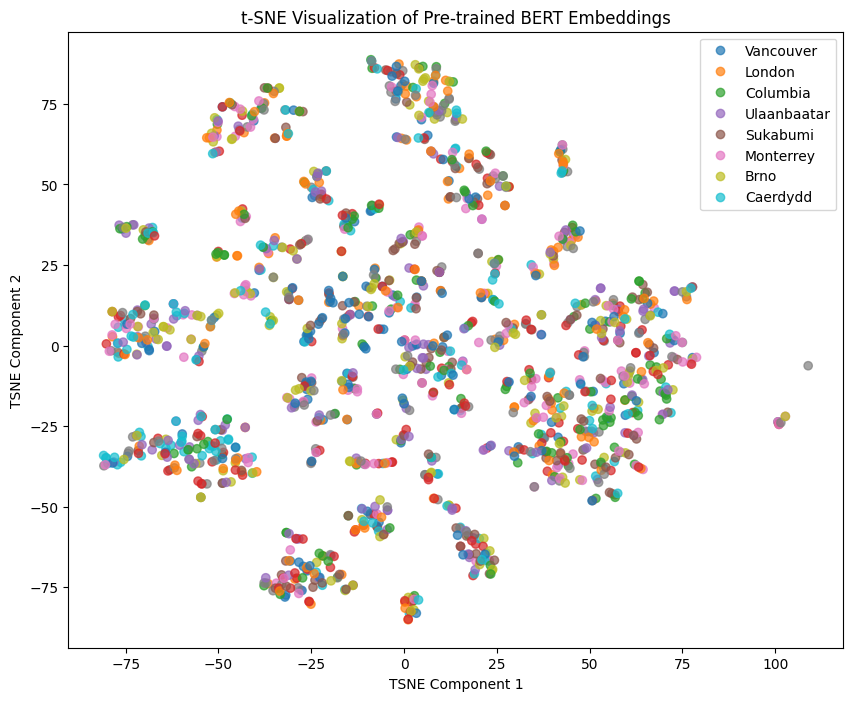

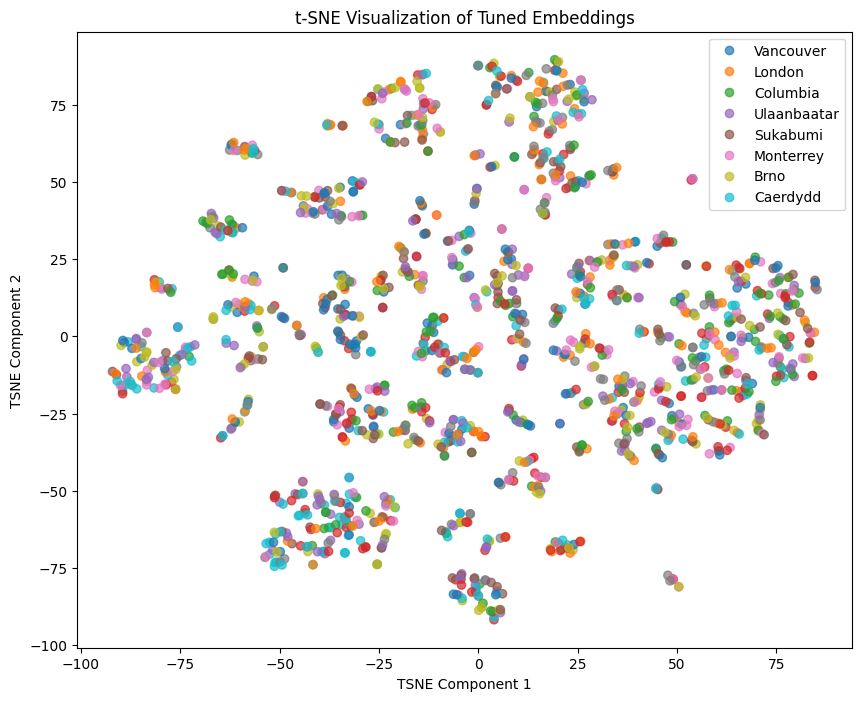

In [ ]:
original_embeddings = embeddings  # From Step 1

# Load the tuned embeddings (after passing through the encoder)
model.encoder.eval()  # Set the encoder to evaluation mode
with torch.no_grad():
    tuned_embeddings = model.encoder(torch.tensor(embeddings, dtype=torch.float32).to(device)).cpu().numpy()

# Prepare labels for visualization (e.g., city names)
labels = data['City'].tolist()

# Function to perform t-SNE and plot
def visualize_embeddings(embeddings, title):
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Create a DataFrame for easy plotting
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'label': labels
    })

    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df['x'], df['y'], c=pd.Categorical(df['label']).codes, cmap='tab10', alpha=0.7)
    plt.legend(handles=scatter.legend_elements()[0], labels=set(labels))
    plt.title(title)
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.show()

# Visualize original embeddings
visualize_embeddings(original_embeddings, 't-SNE Visualization of Pre-trained BERT Embeddings')

# Visualize tuned embeddings
visualize_embeddings(tuned_embeddings, 't-SNE Visualization of Tuned Embeddings')


In [ ]:
# Load the original embeddings (pre-trained BERT embeddings)
original_embeddings = embeddings  # Replace this with the actual loading code if needed

# Ensure the embeddings are on the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.encoder.to(device)  # Move the model to the same device
embeddings_tensor = torch.tensor(original_embeddings, dtype=torch.float32).to(device)

# Generate tuned embeddings (after passing through your encoder)
model.encoder.eval()  # Set the encoder to evaluation mode
with torch.no_grad():
    tuned_embeddings = model.encoder(embeddings_tensor).cpu().numpy()  # Move the result to CPU for further processing

# Prepare labels for visualization (e.g., city names or document labels)
labels = data['City'].tolist()  # Adjust 'City' if your labels are different

In [ ]:
# Apply t-SNE to both sets of embeddings
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
original_tsne = tsne.fit_transform(original_embeddings)
tuned_tsne = tsne.fit_transform(tuned_embeddings)

# Create DataFrames for easy manipulation and plotting
original_df = pd.DataFrame({
    'x': original_tsne[:, 0],
    'y': original_tsne[:, 1],
    'label': labels,
    'embedding_type': 'Pre-trained'
})

tuned_df = pd.DataFrame({
    'x': tuned_tsne[:, 0],
    'y': tuned_tsne[:, 1],
    'label': labels,
    'embedding_type': 'Tuned'
})

# Combine both DataFrames for easier plotting
combined_df = pd.concat([original_df, tuned_df], ignore_index=True)


In [ ]:
import plotly.express as px

# Plot with Plotly, enabling color by label and hover information
fig = px.scatter(
    combined_df, x='x', y='y', color='label',
    facet_col='embedding_type',  # Splits into two plots: Pre-trained vs. Tuned
    title="t-SNE Visualization of Embeddings",
    hover_data={'label': True, 'embedding_type': False}
)

# Customize hover and layout options for better readability
fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.update_layout(
    title="Interactive t-SNE Visualization of Pre-trained and Tuned Embeddings",
    xaxis_title="t-SNE Component 1",
    yaxis_title="t-SNE Component 2"
)

fig.show()

In [ ]:
# Save the tuned embeddings
np.save('tuned_embeddings.npy', tuned_embeddings)